In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

np.set_printoptions(precision=4, suppress=True, linewidth=150)


In [2]:
def soft_greater(x, y=0, resolution=2.0**32):
    return (tf.math.tanh((x - y) * resolution) + 1.0) / 2.0


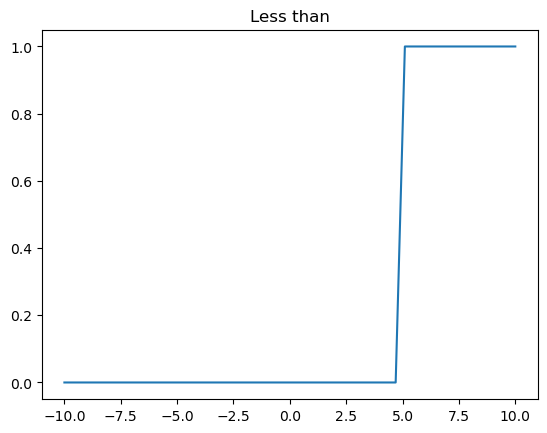

In [4]:
# x = np.linspace(-10, 10)
# y = 5
# plt.plot(x, soft_greater(x, y))
# plt.axis("tight")
# plt.title("Less than")
# plt.show()


In [8]:
def hard_encode(
    x,  # n, dims
    l_lower,  # psi, dims
    l_upper,  # psi, dims
):
    x_encoded = tf.math.reduce_prod(
        tf.cast(
            tf.greater_equal(
                tf.expand_dims(x, axis=1), tf.expand_dims(l_lower, axis=0)
            ),
            dtype=tf.float32,
        ),
        axis=2,
    )
    x_encoded *= tf.math.reduce_prod(
        tf.cast(
            tf.greater(tf.expand_dims(l_upper, axis=0), tf.expand_dims(x, axis=1)),
            dtype=tf.float32,
        ),
        axis=2,
    )

    return x_encoded


def hard_decode(
    x_encoded,  # n, psi
    l_lower,  # psi, dims
    l_upper,  # psi, dims
):
    eps = tf.keras.backend.epsilon()
    g_lower = tf.math.reduce_min(l_lower, axis=0, keepdims=True)
    g_upper = tf.math.reduce_max(l_upper, axis=0, keepdims=True)

    x_lower = tf.expand_dims(x_encoded, axis=2) * tf.expand_dims(
        tf.math.add(l_lower, eps) - g_lower, axis=0
    )
    x_lower = (
        tf.math.reduce_sum(
            tf.one_hot(
                tf.math.argmax(x_lower, axis=1),
                x_encoded.shape[1],
                axis=1,
                dtype=tf.float32,
            )
            * x_lower,
            axis=1,
        )
        - eps
        + g_lower
    )

    x_upper = tf.expand_dims(x_encoded, axis=2) * tf.expand_dims(
        tf.math.subtract(eps, l_upper) + g_upper, axis=0
    )
    x_upper = (
        eps
        + g_upper
        - tf.math.reduce_sum(
            tf.one_hot(
                tf.math.argmax(x_upper, axis=1),
                x_encoded.shape[1],
                axis=1,
                dtype=tf.float32,
            )
            * x_upper,
            axis=1,
        )
    )
    return (x_lower + x_upper) / 2


x, l_lower, l_upper = (
    [
        [-0.1],
        [-0.2],
        [-0.5],
        [-0.8],
    ],
    [
        [-0.3],
        [-0.6],
        [-0.9],
    ],
    [
        [0.0],
        [-0.4],
        [-0.7],
    ],
)

hard_encoded = hard_encode(x, l_lower, l_upper)

print(hard_encoded)
print(hard_decode(hard_encoded, l_lower, l_upper))


tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[-0.15]
 [-0.15]
 [-0.5 ]
 [-0.8 ]], shape=(4, 1), dtype=float32)


In [10]:
def soft_encode(
    x,  # n, dims
    l_lower,  # psi, dims
    l_upper,  # psi, dims
):
    x_encoded = tf.math.reduce_prod(
        soft_greater(tf.expand_dims(x, axis=1), tf.expand_dims(l_lower, axis=0)), axis=2
    )
    x_encoded *= tf.math.reduce_prod(
        soft_greater(tf.expand_dims(l_upper, axis=0), tf.expand_dims(x, axis=1)), axis=2
    )

    return x_encoded


def soft_decode(
    x_encoded,  # n, psi
    l_lower,  # psi, dims
    l_upper,  # psi, dims
):
    eps = tf.keras.backend.epsilon()
    g_lower = tf.math.reduce_min(l_lower, axis=0, keepdims=True)
    g_upper = tf.math.reduce_max(l_upper, axis=0, keepdims=True)

    x_lower = tf.expand_dims(x_encoded, axis=2) * tf.expand_dims(
        tf.math.add(l_lower, eps) - g_lower, axis=0
    )
    x_lower = (
        tf.math.reduce_sum(
            tf.math.softmax(x_lower, axis=1) * x_lower,
            axis=1,
        )
        - eps
        + g_lower
    )

    x_upper = tf.expand_dims(x_encoded, axis=2) * tf.expand_dims(
        tf.math.subtract(eps, l_upper) + g_upper, axis=0
    )
    x_upper = (
        eps
        + g_upper
        - tf.math.reduce_sum(
            tf.math.softmax(x_upper, axis=1) * x_upper,
            axis=1,
        )
    )
    return (x_lower + x_upper) / 2


x, l_lower, l_upper = (
    [
        [-0.1],
        [-0.2],
        [-0.5],
        [-0.8],
    ],
    [
        [-0.3],
        [-0.6],
        [-0.9],
    ],
    [
        [0.0],
        [-0.4],
        [-0.7],
    ],
)

soft_encoded = soft_encode(x, l_lower, l_upper)

print(soft_encoded)
print(soft_decode(soft_encoded, l_lower, l_upper))


tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[-0.307 ]
 [-0.307 ]
 [-0.475 ]
 [-0.6256]], shape=(4, 1), dtype=float32)
